In [34]:
import os
import sys
import yaml
import numpy as np
# add surrDAMH library to the path
sys.path.append(os.path.expanduser("~/Repositories/surrDAMH"))
from surrDAMH.modules import visualization_and_analysis as va  # noqa
from surrDAMH.modules import analysis as ape  # noqa

In [35]:
path_to_data = "~/charon_local"
test_id = "A04hm_H1"
conf_path = "config_mcmc_bayes.yaml"
data_subfolder = "saved_samples"

In [36]:

path_to_data = os.path.expanduser(path_to_data)
# list all the folders in the path_to_data
folders = os.listdir(path_to_data)
# select only folders with the test_id in the name
folders = [f for f in folders if test_id in f]


In [41]:
all_raw_data = []
for i, folder in enumerate(folders):
    print(f"Processing folder {i+1}/{len(folders)} named {folder}")
    full_path = os.path.join(path_to_data, folder, data_subfolder)
    # PREPARATION:
    basename = os.path.basename(conf_path)
    problem_name, fext = os.path.splitext(basename)

    output_dir = os.path.join(full_path, problem_name)


    with open(conf_path) as f:
        conf = yaml.safe_load(f)

    # set conf["no_observation"] to 26 if folders[i] contains _nocond_ and 30 if not
    conf["no_observations"] = 26 if "_nocond_" in folder else 30


    observations = np.array(conf["problem_parameters"]["observations"])[:conf["no_observations"]]
    no_parameters = conf["no_parameters"]

    # LOAD DATA:
    raw_data = ape.RawData()
    raw_data.load(output_dir, no_parameters, len(observations))
    all_raw_data.append(raw_data)


Processing folder 1/11 named synth_A04hm_H1_nocond_nocorr_20230602
raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 577105
raw data: no_nonconverging 0
raw data: p (577105, 8)
raw data: w (577105, 1)
raw_data: np.sum(weights): 561498
Processing folder 2/11 named synth_A04hm_H1_20230418
raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 495114
raw data: no_nonconverging 0
raw data: p (495114, 8)
raw data: w (495114, 1)
raw_data: np.sum(weights): 490146
Processing folder 3/11 named synth_A04hm_H1_20230329
raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 512563
raw data: no_nonconverging 0
raw data: p (512563, 8)
raw data: w (512563, 1)
raw_data: np.sum(weights): 507951
Processing folder 4/11 named synth_A04hm_H1_20230412
raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 462612
raw data: no_nonconverging 0
raw data: p (462612, 8)
raw data: w (462612, 1)
raw_data: np.sum(weights): 457043
Processing folder 5/11 named synth_A04

In [45]:
all_raw_data[0].stages


array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [62]:
all_parameters = []
all_observations = []

for raw_data in all_raw_data:
    raw_data_filtered = raw_data.filter(types=[0, 2], stages=[0, 1])
    all_parameters.append(raw_data_filtered.parameters)
    all_observations.append(raw_data_filtered.observations[:, :26])

all_parameters = np.concatenate(all_parameters)
all_observations = np.concatenate(all_observations)

filter raw data: p (13514, 8)
filter raw data: p (24844, 8)
filter raw data: p (32106, 8)
filter raw data: p (24191, 8)
filter raw data: p (23731, 8)
filter raw data: p (26282, 8)
filter raw data: p (23454, 8)
filter raw data: p (26742, 8)
filter raw data: p (24190, 8)
filter raw data: p (26833, 8)
filter raw data: p (22899, 8)


In [73]:
n_filt = all_parameters.shape[0]
m_filt = all_observations.shape[1]
k_filt = all_parameters.shape[1]

# transform data according to conf['transformations']
parameters_transformed_filt = all_parameters.copy()

for i in range(parameters_transformed_filt.shape[1]):
    parameters_transformed_filt[:, i] = (np.log(all_parameters[:, i]) -
                                         conf['transformations'][i]['options']['mu']) / conf['transformations'][i]['options']['sigma']

all_parameters_normalized = parameters_transformed_filt

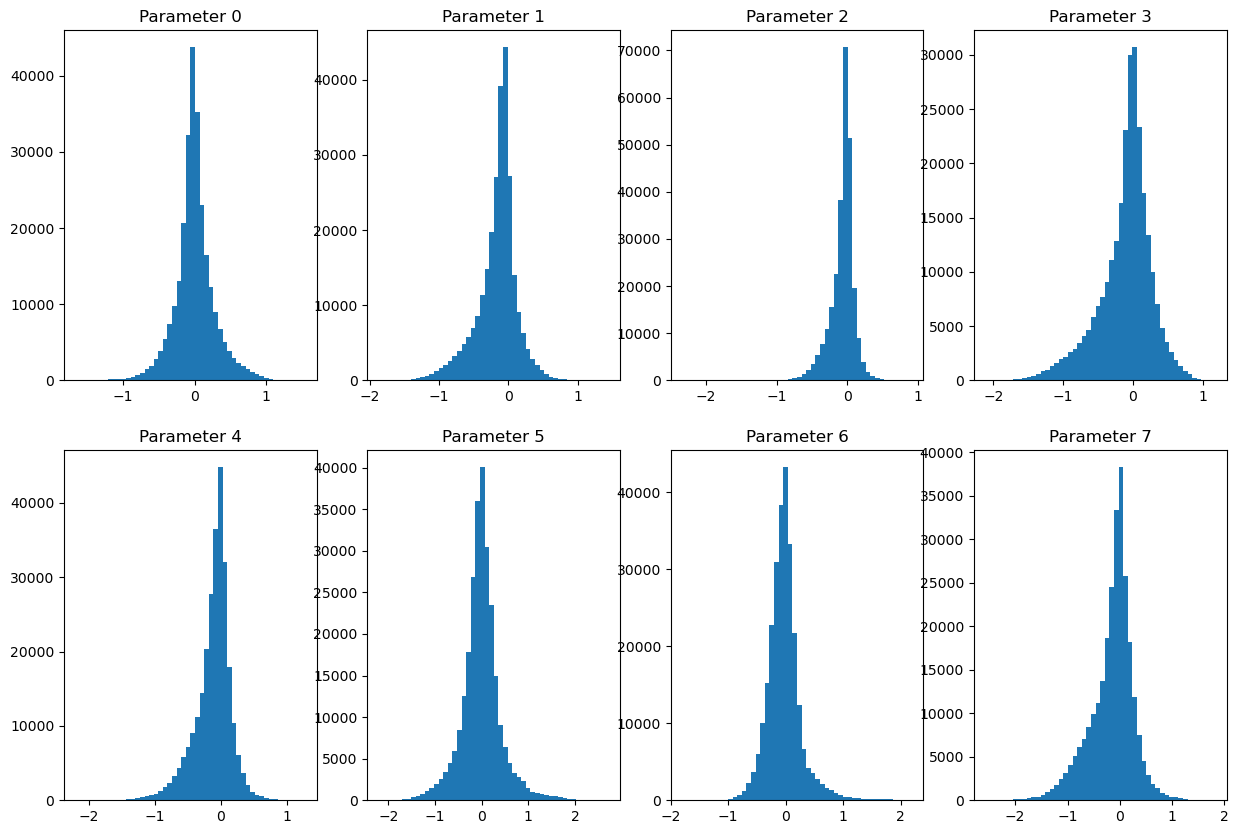

In [67]:
import matplotlib.pyplot as plt
# plot histograms of the parameters in a grid 2x4
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs = axs.ravel()
for i in range(k_filt):
    axs[i].hist(parameters_transformed_filt[:, i], bins=50)
    axs[i].set_title(f"Parameter {i}")


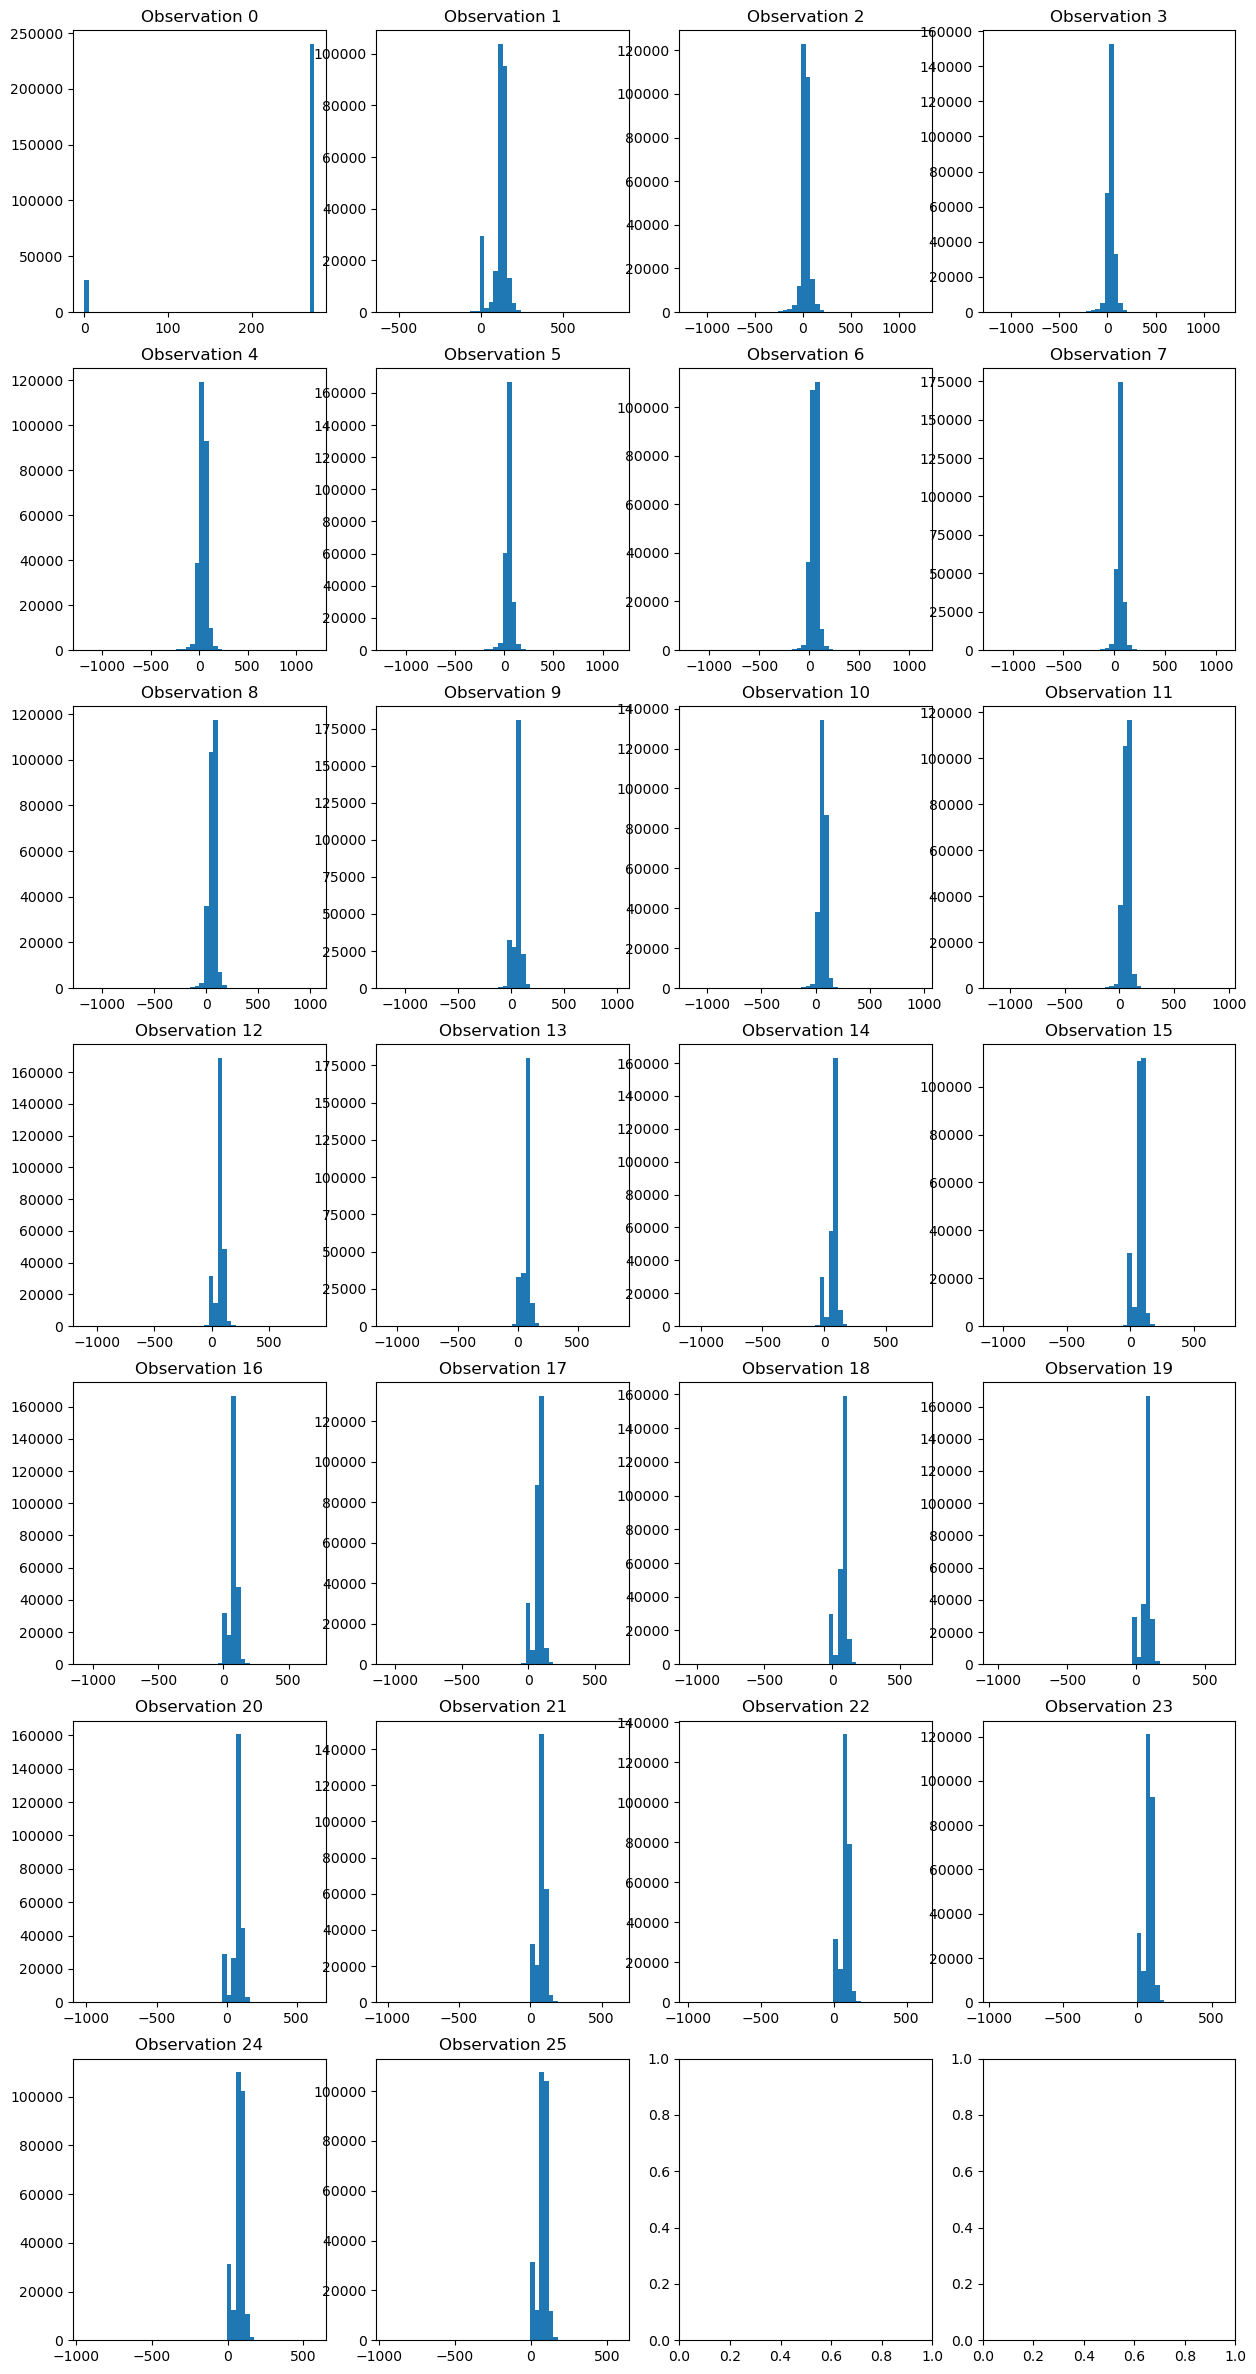

In [72]:
# plot histograms of the observations in a grid 10x3
fig, axs = plt.subplots(7, 4, figsize=(15, 30))
axs = axs.ravel()
for i in range(m_filt):
    axs[i].hist(all_observations[:, i], bins=50)
    axs[i].set_title(f"Observation {i}")



In [74]:
# save all_parameters_normalized, all_parameters and all_observations to a hdf5 file
import h5py
with h5py.File(f"{test_id}_data.hdf5", "w") as f:
    f.create_dataset("all_parameters_normalized", data=all_parameters_normalized)
    f.create_dataset("all_parameters", data=all_parameters)
    f.create_dataset("all_observations", data=all_observations)

In [78]:
import gzip
with open(f"{test_id}_data.hdf5", "rb") as f_in:
    with gzip.open(f"{test_id}_data.hdf5.gz", "wb", compresslevel=9) as f_out:
        f_out.writelines(f_in)
